# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python 3 code to simulate exciton-polaritons in lattices.

### Contents:
* Section 1: 
* Section 2: 
* Section 3: 

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Physical constants and parameters

In [9]:
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
hbar=1.05e-34 # reduced Planck constant, J s
dum=3. # um
d=dum*1.e-6 # m
E0=hbar*hbar/(2.*meff*d*d)/(1.6e-22) # characteristic energy, meV
print('E0 = %f meV' % E0)

E0 = 0.084135 meV


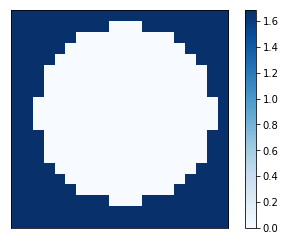

In [11]:
### Source: ucreate.py

Mhalf=10
M=2*Mhalf
Lcell=1.

dr=Lcell/M
dr2=dr*dr
Uout=20
Uin=0

Rbound=(0.41/dr)**2
U=Uout*np.ones((M,M),dtype=np.float64)
for i in range(M):
    for j in range(M):
#        for cx,cy in [(0,Mhalf),(Mhalf,0),(Mhalf,Mhalf),(Mhalf,M),(M,Mhalf)]:
        for cx,cy in [(Mhalf,Mhalf)]:
            di=i-cx
            dj=j-cy
            if(di*di+dj*dj <= Rbound):
                U[i,j] = Uin

cmap=plt.get_cmap('Blues')
data=E0*U.real
img=plt.imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar(img,cmap=cmap)
plt.show()

In [12]:
M

20

In [22]:
### Source: lieb-bands.py

from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigsh
import time

#exec(open('ucreate.py').read())

NBzones=2
Nvals=30
Nkpoints=70

ky=math.pi

### Constructing matrix

Imat=np.ones(M*M,dtype=np.complex128)

Itop=np.ones(M,dtype=np.complex128)
Itop[0]=0.
Itopmat=np.array([Itop]*M).ravel()

Ibot=np.ones(M,dtype=np.complex128)
Ibot[-1]=0.
Ibotmat=np.array([Ibot]*M).ravel()

'''
### Calculating eigenvalues: general
start_time = time.time()
evals0=np.linalg.eigvalsh(matrix)[:Nvals]/(dr*dr)
print('evals0:')
print(evals0)
print('#')
print("# Timing: %.f seconds" % (time.time()-start_time))
print('#')
'''

kxrange=np.linspace(-NBzones*math.pi/Lcell, NBzones*math.pi/Lcell,Nkpoints)

start_time = time.time()
evlist=[]

for kx in kxrange:

    ekx=np.exp(-1j*kx*Lcell)
    eky=np.exp(-1j*ky*Lcell)
    ekytop=np.zeros(M,dtype=np.complex128)
    ekybot=np.zeros(M,dtype=np.complex128)
    ekytop[-1]=-eky
    ekybot[0]=-np.conjugate(eky)
    topmat=np.array([ekytop]*M).ravel()
    botmat=np.array([ekybot]*M).ravel()

    data=[botmat,-Imat*np.conjugate(ekx),-Imat,-Ibotmat,4.*Imat + dr2*U.ravel(),-Itopmat,-Imat,-Imat*ekx,topmat]
    offset=[-(M-1),-M*(M-1),-M,-1,0,1,M,M*(M-1),M-1]
    dmatrix=dia_matrix((data, offset), shape=(M*M, M*M))
    spmatrix=csc_matrix(dmatrix)
    evals=np.sort(eigsh(spmatrix, return_eigenvectors=False, k=Nvals, sigma=0))/dr2

#    matrix=dmatrix.toarray()
#    evals0=np.linalg.eigvalsh(matrix)[:Nvals]/dr2

    evlist.append(evals)

evlist=np.array(evlist)

#np.savez('U'+str(Ulist[nu])+'_Pky_'+str(Pky),kxrange=kxrange,evlist=evlist)

print('#')
print("# Timing: %.f seconds" % (time.time()-start_time))
print('#')

#
# Timing: 2 seconds
#


In [23]:
print('check:')
for m in range(4):
    for n in range(4):
        print('n: %d, m: %d, E: %f' % ( n, m, (2.*math.pi/Lcell)**2*(m*m+n*n) ))

check:
n: 0, m: 0, E: 0.000000
n: 1, m: 0, E: 39.478418
n: 2, m: 0, E: 157.913670
n: 3, m: 0, E: 355.305758
n: 0, m: 1, E: 39.478418
n: 1, m: 1, E: 78.956835
n: 2, m: 1, E: 197.392088
n: 3, m: 1, E: 394.784176
n: 0, m: 2, E: 157.913670
n: 1, m: 2, E: 197.392088
n: 2, m: 2, E: 315.827341
n: 3, m: 2, E: 513.219429
n: 0, m: 3, E: 355.305758
n: 1, m: 3, E: 394.784176
n: 2, m: 3, E: 513.219429
n: 3, m: 3, E: 710.611517


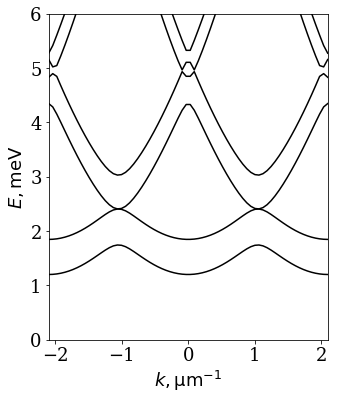

In [35]:
### Source: cbands.py

plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(figsize=(5,6))

for i in range(evlist.shape[1]):
    ax.plot(kxrange/dum,E0*evlist[:,i],'k')

ax.set_xlim([kxrange[0]/dum,kxrange[-1]/dum])
ax.set_ylim([0,6])
ax.set_xlabel(r"$k, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")
ax.set_xticks([-2,-1,0,1,2])
plt.show()

In [41]:
### Source: lieb-vectors.py

from pylab import *
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigsh
import time

kx=math.pi
ky=math.pi


Nvals=30

### Constructing matrix

Imat=np.ones(M*M,dtype=np.complex128)

Itop=np.ones(M,dtype=np.complex128)
Itop[0]=0.
Itopmat=np.array([Itop]*M).ravel()

Ibot=np.ones(M,dtype=np.complex128)
Ibot[-1]=0.
Ibotmat=np.array([Ibot]*M).ravel()

start_time = time.time()

ekx=np.exp(-1j*kx*Lcell)
eky=np.exp(-1j*ky*Lcell)
ekytop=np.zeros(M,dtype=np.complex128)
ekybot=np.zeros(M,dtype=np.complex128)
ekytop[-1]=-eky
ekybot[0]=-conjugate(eky)
topmat=np.array([ekytop]*M).ravel()
botmat=np.array([ekybot]*M).ravel()

data=[botmat,-Imat*conjugate(ekx),-Imat,-Ibotmat,4.*Imat + dr2*U.ravel(),-Itopmat,-Imat,-Imat*ekx,topmat]
offset=[-(M-1),-M*(M-1),-M,-1,0,1,M,M*(M-1),M-1]
dmatrix=dia_matrix((data, offset), shape=(M*M, M*M))
spmatrix=csc_matrix(dmatrix)
#evals=sort(eigsh(spmatrix, return_eigenvectors=False, k=Nvals, sigma=0))/dr2
evalsunsorted,Tevecs=eigsh(spmatrix, return_eigenvectors=True, k=Nvals, sigma=0)
evalsunsorted/=dr2
evecsunsorted=Tevecs.T

inds=argsort(evalsunsorted)
evals=evalsunsorted[inds]
evecs=evecsunsorted[inds]

# np.savez('temp',temp=temp)

#print('#')
#print("# Timing: %.f seconds" % (time.time()-start_time))
#print('#')

#els=np.where((ens>2) & (ens<2.5))
#print('Selected values (sparse):')
#print(ens[els])


### Calculating eigenvalues: general
start_time = time.time()
matrix=dmatrix.toarray()
evals0=np.linalg.eigvalsh(matrix)[:Nvals]/dr2
ens0=E0*evals0
#print('#')
#print("# Timing: %.f seconds" % (time.time()-start_time))
#print('#')

#print('Selected values (general method):')
#print(ens0[els])

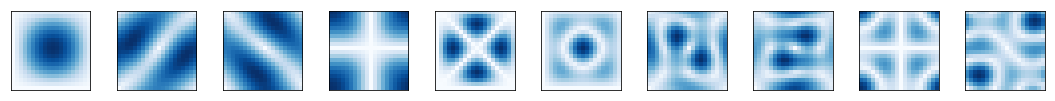

In [72]:
### Source: cvec.py

nvmax=10 # number of eigenvectors to display
plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(1,nvmax,figsize=(15,2))

#print('Eigenvalue:')
#print(ens0[els])

cmap=plt.get_cmap('Blues')

for nv in range(nvmax):
    data=np.abs(evecs[nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])

plt.tight_layout()
plt.show()